# Importing some packages

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import calendar
from scipy.signal import periodogram
from scipy.stats import iqr
from statsmodels.tsa.deterministic import CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from tqdm import tqdm
import pytz

plt.rcParams.update({'figure.figsize': (20, 10)})

# Loading the data

In [2]:
datagh = pd.read_excel('/content/Kay Bailey - Rio Grande at Narrows NM Gage Height Data.xlsx')
datagh = datagh.iloc[1:, :].dropna().reset_index(drop=True)

rename_dict = {
    "agency_cd": "Agency_Code (5s)",
    "site_no": "Site_Number (15s)",
    "datetime":	"DateTime (20d)",
    "tz_cd": "Time_Zone (6s)",
    "101299_00065": "Gage_Height (14n)",
    "101299_00065_cd": "Quality_Code",
    "101298_00060": "Discharge (14n)",
    "101298_00060_cd": "Quality_Code",
}

datagh.rename(columns=rename_dict, inplace=True)

datad = pd.read_excel('/content/Kay Bailey - Rio Grande at Narrows NM Discharge Data.xlsx')
datad = datad.iloc[1:, :].dropna().reset_index(drop=True)
datad.rename(columns=rename_dict, inplace=True)

datagh['DateTime (20d)'] = pd.to_datetime(datagh['DateTime (20d)'])
datad['DateTime (20d)'] = pd.to_datetime(datad['DateTime (20d)'])

datad = datad[datad['Quality_Code']=='A'].reset_index(drop=True)

datad = datad[~datad.drop(columns=['Time_Zone (6s)']).duplicated()]
datad.sort_values('DateTime (20d)', ascending=True, inplace=True)
datad.reset_index(drop=True, inplace=True)

datagh = datagh[~datagh.drop(columns=['Time_Zone (6s)']).duplicated()]
datagh.sort_values('DateTime (20d)', ascending=True, inplace=True)
datagh.reset_index(drop=True, inplace=True)

<ipython-input-2-830ef03fa3f5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datagh.sort_values('DateTime (20d)', ascending=True, inplace=True)


There some datapoints that has been recorded not after 15 minutes, but after 30 minutes, 45 minutes, etc. Let's fill in the missing datapoints using the previous available values. In nutshell, we will add the missing datetimes and apply fill forward methodology for discharge and gage height.

In [3]:
datagh['second_diff'] = datagh['DateTime (20d)'].diff().dt.total_seconds()/60
datagh['second_diff'].fillna(15.0, inplace=True)

diff_values = list(datagh['second_diff'])
date_values = list(datagh['DateTime (20d)'])
cage_height_values = list(datagh['Gage_Height (14n)'])

date_list = []
cage_height_list = []

for i in range(len(diff_values)):
    if diff_values[i] != 15:
        n_iters = int(diff_values[i] / 15) - 1
        for j in range(1, n_iters+1):
            date_list.append(date_values[i]-timedelta(minutes=15*j))
            cage_height_list.append(cage_height_values[i-1])

temp_df = pd.DataFrame(
    {
        'DateTime (20d)': date_list,
        'Gage_Height (14n)': cage_height_list
    }
)


cols_4drop_list = [
    'Agency_Code (5s)',
    'Time_Zone (6s)',
    'Quality_Code',
    'Site_Number (15s)',
    'second_diff'
]

datagh.drop(columns=cols_4drop_list, inplace=True)

datagh = pd.concat([datagh, temp_df], axis=0)
datagh.sort_values('DateTime (20d)', ascending=True, inplace=True)
datagh.reset_index(drop=True, inplace=True)
datagh.shape

<ipython-input-3-ee4112032ae5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datagh['second_diff'] = datagh['DateTime (20d)'].diff().dt.total_seconds()/60
<ipython-input-3-ee4112032ae5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datagh['second_diff'].fillna(15.0, inplace=True)


(132334, 2)

In [4]:
datad['second_diff'] = datad['DateTime (20d)'].diff().dt.total_seconds()/60
datad['second_diff'].fillna(15.0, inplace=True)

diff_values = list(datad['second_diff'])
date_values = list(datad['DateTime (20d)'])
discharge_values = list(datad['Discharge (14n)'])

date_list = []
discharge_list = []

for i in range(len(diff_values)):
    if diff_values[i] != 15:
        n_iters = int(diff_values[i] / 15) - 1
        for j in range(1, n_iters+1):
            date_list.append(date_values[i]-timedelta(minutes=15*j))
            discharge_list.append(discharge_values[i-1])

temp_df = pd.DataFrame(
    {
        'DateTime (20d)': date_list,
        'Discharge (14n)': discharge_list
    }
)


cols_4drop_list = [
    'Agency_Code (5s)',
    'Time_Zone (6s)',
    'Quality_Code',
    'Site_Number (15s)',
    'second_diff'
]

datad.drop(columns=cols_4drop_list, inplace=True)

datad = pd.concat([datad, temp_df], axis=0)
datad.sort_values('DateTime (20d)', ascending=True, inplace=True)
datad.reset_index(drop=True, inplace=True)
datad.shape

(149102, 2)

Converting Discharge and Gage height to float

In [5]:
datad['Discharge (14n)'] = datad['Discharge (14n)'].apply(float)
datagh['Gage_Height (14n)'] = datagh['Gage_Height (14n)'].apply(float)

Creating features based on polynomial of the time step feature

In [6]:
datagh['time_step'] = np.arange(1, datagh.shape[0]+1)
datad['time_step'] = np.arange(1, datad.shape[0]+1)

datad['time_step2'] = datad['time_step'] ** 2
datagh['time_step2'] = datagh['time_step'] ** 2

datad['time_step3'] = datad['time_step'] ** 3
datagh['time_step3'] = datagh['time_step'] ** 3

The next step will be to create some new features out of the datetime column and check their importance for prediction. Actually the created features will help identify the seasonality in some sense.

In [7]:
datagh['week'] = datagh['DateTime (20d)'].dt.isocalendar().week
datagh['year'] = datagh['DateTime (20d)'].dt.year
datagh['dayofweek'] = datagh['DateTime (20d)'].dt.dayofweek
datagh['hour'] = datagh['DateTime (20d)'].dt.hour
datagh['month'] = datagh['DateTime (20d)'].dt.month
datagh['day'] = datagh['DateTime (20d)'].dt.day
datagh['weekofmonth'] = datagh['day'].apply(lambda x: (x-1) // 7 + 1)

In [8]:
datad['week'] = datad['DateTime (20d)'].dt.isocalendar().week
datad['year'] = datad['DateTime (20d)'].dt.year
datad['dayofweek'] = datad['DateTime (20d)'].dt.dayofweek
datad['hour'] = datad['DateTime (20d)'].dt.hour
datad['month'] = datad['DateTime (20d)'].dt.month
datad['day'] = datad['DateTime (20d)'].dt.day
datad['weekofmonth'] = datad['day'].apply(lambda x: (x-1) // 7 + 1)

In [9]:
month_names_list = list(calendar.month_name)
month_names_list = [month_str for month_str in month_names_list if month_str!='']

Creating more features

In [10]:
# creating dummy features out dayofweek and merging with the data
dayofweek_dummy_d = pd.get_dummies(datad['dayofweek'], drop_first=True, prefix='day')
datad = pd.concat([datad, dayofweek_dummy_d], axis=1)
dayofweek_dummy_gh = pd.get_dummies(datagh['dayofweek'], drop_first=True, prefix='day')
datagh = pd.concat([datagh, dayofweek_dummy_gh], axis=1)

# setting some parameters
N_LAGS = 8 # number of lags
FT_PERIODS = 5 # periods for Fourier series

# creating lag features
for i in range(1, N_LAGS+1):
    datad[f'lag{i}_discharge'] = datad['Discharge (14n)'].shift(i)
    datagh[f'lag{i}_gage'] = datagh['Gage_Height (14n)'].shift(i)

# removing rows containing missing values
datad.dropna(inplace=True)
datad.reset_index(drop=True, inplace=True)

datagh.dropna(inplace=True)
datagh.reset_index(drop=True, inplace=True)

# dropping some columns from the data
datad.drop(
    columns=[
        'time_step2', 'time_step3', 'year',
        'week', 'hour', 'day',
        'weekofmonth', 'dayofweek'
    ],
    inplace=True
)

datagh.drop(
    columns=[
        'time_step2', 'time_step3', 'year',
        'week', 'hour', 'day',
        'weekofmonth', 'dayofweek'
    ],
    inplace=True
)

def replace_outliers(df, series_name):
    # finding interquantile range
    Q1 = df[series_name].quantile(0.25)
    Q3 = df[series_name].quantile(0.75)
    IQR = Q3 - Q1

    # creating boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_mask = (df[series_name] <= lower_bound) | (df[series_name] >= upper_bound)
    nooutlier_mask = (df[series_name] > lower_bound) | (df[series_name] < upper_bound)

    replace_value = df[nooutlier_mask][series_name].mean()

    df.loc[outlier_mask, series_name] = replace_value

    return df

# conducting the train-test split
traind = datad.iloc[:-35040].copy().reset_index(drop=True)
# traind = replace_outliers(df=traind, series_name='Discharge (14n)')
testd = datad.iloc[-35040:].copy().reset_index(drop=True)

traingh = datagh.iloc[:-35040].copy().reset_index(drop=True)
# traingh = replace_outliers(df=traingh, series_name='Gage_Height (14n)')
testgh = datagh.iloc[-35040:].copy().reset_index(drop=True)

# creating a dictionary for median by month and the series based on train set
monthly_median_mapd = traind.groupby('month')['Discharge (14n)'].median().to_dict()

monthly_median_mapgh = traingh.groupby('month')['Gage_Height (14n)'].median().to_dict()

# mapping the median monthly values of the series to train and test sets
traind['discharge_median'] = traind['month'].map(monthly_median_mapd)
traingh['gage_median'] = traingh['month'].map(monthly_median_mapgh)

testd['discharge_median'] = testd['month'].map(monthly_median_mapd)
testgh['gage_median'] = testgh['month'].map(monthly_median_mapgh)

# creating a dictionary for iterquantile range by month and the series based on train set
monthly_iqr_mapd = traind.groupby('month')['Discharge (14n)'].agg(iqr).to_dict()
monthly_iqr_mapgh = traingh.groupby('month')['Gage_Height (14n)'].agg(iqr).to_dict()

# mapping the interquantile range monthly values of the series to train and test sets
traind['discharge_iqr'] = traind['month'].map(monthly_iqr_mapd)
traingh['gage_iqr'] = traingh['month'].map(monthly_iqr_mapgh)

testd['discharge_iqr'] = testd['month'].map(monthly_iqr_mapd)
testgh['gage_iqr'] = testgh['month'].map(monthly_iqr_mapgh)

traind.drop(columns='month', inplace=True)
traingh.drop(columns='month', inplace=True)
testd.drop(columns='month', inplace=True)
testgh.drop(columns='month', inplace=True)

# creating a dataframe to assign features for 5 years ahead prediction
prediction_featuresd = pd.DataFrame()
prediction_featuresgh = pd.DataFrame()
n_15minutes_prediction = 4 * 24 * 365 * 5

prediction_featuresd['DateTime (20d)'] = pd.date_range(
    start=(
        datad.iloc[-1]['DateTime (20d)']+timedelta(minutes=15)
    ).strftime('%Y-%m-%d %H:%M:%S'),
    periods=n_15minutes_prediction,
    freq='15T'
)

prediction_featuresgh['DateTime (20d)'] = pd.date_range(
    start=(
        datagh.iloc[-1]['DateTime (20d)']+timedelta(minutes=15)
    ).strftime('%Y-%m-%d %H:%M:%S'),
    periods=n_15minutes_prediction,
    freq='15T'
)

prediction_featuresd['time_step'] = np.arange(
    datad.shape[0]+1,
    datad.shape[0] + n_15minutes_prediction+1
)

prediction_featuresgh['time_step'] = np.arange(
    datagh.shape[0]+1,
    datagh.shape[0] + n_15minutes_prediction+1
)
# prediction_features.set_index('DateTime (20d)', inplace=True)
prediction_featuresd['month'] = prediction_featuresd['DateTime (20d)'].dt.month
prediction_featuresgh['month'] = prediction_featuresgh['DateTime (20d)'].dt.month

prediction_featuresd['discharge_median'] = prediction_featuresd['month'].map(
    monthly_median_mapd
)
prediction_featuresgh['gage_median'] = prediction_featuresgh['month'].map(
    monthly_median_mapgh
)
prediction_featuresd['discharge_iqr'] = prediction_featuresd['month'].map(
    monthly_iqr_mapd
)
prediction_featuresgh['gage_iqr'] = prediction_featuresgh['month'].map(
    monthly_iqr_mapgh
)

prediction_featuresd['dayofweek'] = prediction_featuresd['DateTime (20d)'].dt.dayofweek
prediction_featuresgh['dayofweek'] = prediction_featuresgh['DateTime (20d)'].dt.dayofweek

prediction_dayofweek_dummyd = pd.get_dummies(
    prediction_featuresd['dayofweek'],
    drop_first=True,
    prefix='day'
)

prediction_dayofweek_dummygh = pd.get_dummies(
    prediction_featuresgh['dayofweek'],
    drop_first=True,
    prefix='day'
)

prediction_featuresd = pd.concat(
    [
        prediction_featuresd,
        prediction_dayofweek_dummyd
    ],
    axis=1
)

prediction_featuresgh = pd.concat(
    [
        prediction_featuresgh,
        prediction_dayofweek_dummygh
    ],
    axis=1
)

prediction_featuresd.drop(columns=['month', 'dayofweek'], inplace=True)
prediction_featuresgh.drop(columns=['month', 'dayofweek'], inplace=True)

# creating Fourier series and merging with train, test, and prediction sets
cal_fourier_gend = CalendarFourier("A", FT_PERIODS)
indexd = pd.DatetimeIndex(traind['DateTime (20d)'])

cal_fourier_gengh = CalendarFourier("A", FT_PERIODS)
indexgh = pd.DatetimeIndex(traingh['DateTime (20d)'])

fourier_series_traind = cal_fourier_gend.in_sample(indexd)
fourier_series_traind.columns = [
    f'sin{int(i/2)+1}'
    if i%2==0 else f'cos{int(i/2)+1}'
    for i in range(FT_PERIODS*2)
]
fourier_series_traind.reset_index(inplace=True)
fourier_series_traind.rename(columns={'index': 'DateTime (20d)'}, inplace=True)

fourier_series_traingh = cal_fourier_gengh.in_sample(indexgh)
fourier_series_traingh.columns = [
    f'sin{int(i/2)+1}'
    if i%2==0 else f'cos{int(i/2)+1}'
    for i in range(FT_PERIODS*2)
]
fourier_series_traingh.reset_index(inplace=True)
fourier_series_traingh.rename(columns={'index': 'DateTime (20d)'}, inplace=True)

# train.set_index('DateTime (20d)', inplace=True)
# train = pd.concat([train, fourier_series_train], axis=0)
traind = pd.merge(traind, fourier_series_traind, on='DateTime (20d)')
traingh = pd.merge(traingh, fourier_series_traingh, on='DateTime (20d)')

out_of_sample_periods = 35040 + n_15minutes_prediction

fourier_series_testd = cal_fourier_gend.out_of_sample(
    steps=out_of_sample_periods,
    index=pd.date_range(
        start=traind.iloc[0]['DateTime (20d)'].strftime('%Y-%m-%d %H:%M:%S'),
        periods=traind.shape[0],
        freq='15T'
    )
)

fourier_series_testgh = cal_fourier_gengh.out_of_sample(
    steps=out_of_sample_periods,
    index=pd.date_range(
        start=traingh.iloc[0]['DateTime (20d)'].strftime('%Y-%m-%d %H:%M:%S'),
        periods=traingh.shape[0],
        freq='15T'
    )
)

fourier_series_testd.columns = [
    f'sin{int(i/2)+1}'
    if i%2==0 else f'cos{int(i/2)+1}'
    for i in range(FT_PERIODS*2)
]

fourier_series_testgh.columns = [
    f'sin{int(i/2)+1}'
    if i%2==0 else f'cos{int(i/2)+1}'
    for i in range(FT_PERIODS*2)
]

fourier_series_testd.reset_index(inplace=True)
fourier_series_testd.rename(columns={'index': 'DateTime (20d)'}, inplace=True)

fourier_series_testgh.reset_index(inplace=True)
fourier_series_testgh.rename(columns={'index': 'DateTime (20d)'}, inplace=True)

testd = pd.merge(testd, fourier_series_testd, on='DateTime (20d)')
prediction_featuresd = pd.merge(prediction_featuresd, fourier_series_testd, on='DateTime (20d)')

testgh = pd.merge(testgh, fourier_series_testgh, on='DateTime (20d)')
prediction_featuresgh = pd.merge(prediction_featuresgh, fourier_series_testgh, on='DateTime (20d)')

y_traind = traind['Discharge (14n)'].to_frame()
y_traingh = traingh['Gage_Height (14n)'].to_frame()

X_traind = traind[
    [
        col for col in traind.columns
        if col not in ['Discharge (14n)']
    ]
].copy()

X_traingh = traingh[
    [
        col for col in traingh.columns
        if col not in ['Gage_Height (14n)']
    ]
].copy()

y_testd = testd['Discharge (14n)'].to_frame()
y_testgh = testgh['Gage_Height (14n)'].to_frame()

X_testd = testd[
    [
        col for col in testd.columns
        if col not in ['Discharge (14n)']
    ]
].copy()

X_testgh = testgh[
    [
        col for col in testgh.columns
        if col not in ['Gage_Height (14n)']
    ]
].copy()

print(f'Train size: {X_traind.shape}')
print(f'Test size: {X_testd.shape}')
print(f'Prediction size: {prediction_featuresd.shape}')

print(f'Train size: {X_traingh.shape}')
print(f'Test size: {X_testgh.shape}')
print(f'Prediction size: {prediction_featuresgh.shape}')

Train size: (114062, 28)
Test size: (35027, 28)
Prediction size: (175200, 20)
Train size: (97294, 28)
Test size: (35028, 28)
Prediction size: (175200, 20)


## Hybrid model

Now we can proceed to model creation. A hybrid model will be used. Specifically we apply linear regression using trend and seasonality features. Then we will subtract the estimates of trend and seasonality from the series and apply XBGRession using the rest of the features. To make a prediction we will sum the predictions from the 2 models.

In [11]:
# creating linear regression model
lr_featuresd = [
    col for col in X_traind.columns
    if col.startswith('day') or col.startswith('sin') or col.startswith('cos')
]

lr_featuresgh = [
    col for col in X_traingh.columns
    if col.startswith('day') or col.startswith('sin') or col.startswith('cos')
]
# lr_features.append('time_step')

lrd = LinearRegression()
lrd.fit(X_traind[lr_featuresd], y_traind)

lrgh = LinearRegression()
lrgh.fit(X_traingh[lr_featuresgh], y_traingh)

# predicting the series using the estimated linear regression
lr_series_traind = lrd.predict(X_traind[lr_featuresd])
lr_series_traind = pd.DataFrame(lr_series_traind, columns=y_traind.columns)

lr_series_traingh = lrgh.predict(X_traingh[lr_featuresgh])
lr_series_traingh = pd.DataFrame(lr_series_traingh, columns=y_traingh.columns)

# removing the prediction of linear regression to prepare the new target variable
y_train_xgbd = y_traind - lr_series_traind

y_train_xgbgh = y_traingh - lr_series_traingh

# separating features for xgboost for each series
discharge_features = [
    col for col in X_traind.columns
    if col.startswith('discharge') or col.endswith('discharge')
]

gage_features = [
    col for col in X_traingh.columns
    if col.startswith('gage') or col.endswith('gage')
]

# creating XGBoost models
xgb_discharged = XGBRegressor()
xgb_discharged.fit(X_traind[discharge_features], y_train_xgbd['Discharge (14n)'])

xgb_gagegh = XGBRegressor()
xgb_gagegh.fit(X_traingh[gage_features], y_train_xgbgh['Gage_Height (14n)'])

xgb_series_traind = pd.DataFrame()
xgb_series_traind['Discharge (14n)'] = xgb_discharged.predict(X_traind[discharge_features])

xgb_series_traingh = pd.DataFrame()
xgb_series_traingh['Gage_Height (14n)'] = xgb_gagegh.predict(X_traingh[gage_features])

# creating final predictions for train and test sets
final_train_predictiond = xgb_series_traind + lr_series_traind
final_train_predictiond.index = X_traind['DateTime (20d)']

final_train_predictiongh = xgb_series_traingh + lr_series_traingh
final_train_predictiongh.index = X_traingh['DateTime (20d)']

final_train_predictiond['Discharge (14n)'] = final_train_predictiond['Discharge (14n)'].apply(
    lambda x: traind['Discharge (14n)'].min() if x <=0 else x
)

final_train_predictiongh['Gage_Height (14n)'] = final_train_predictiongh['Gage_Height (14n)'].apply(
    lambda x: traingh['Gage_Height (14n)'].min() if x <=0 else x
)

lr_series_testd = lrd.predict(X_testd[lr_featuresd])
lr_series_testd = pd.DataFrame(lr_series_testd, columns=y_traind.columns)

lr_series_testgh = lrgh.predict(X_testgh[lr_featuresgh])
lr_series_testgh = pd.DataFrame(lr_series_testgh, columns=y_traingh.columns)

xgb_series_testd = pd.DataFrame()
xgb_series_testd['Discharge (14n)'] = xgb_discharged.predict(X_testd[discharge_features])

xgb_series_testgh = pd.DataFrame()
xgb_series_testgh['Gage_Height (14n)'] = xgb_gagegh.predict(X_testgh[gage_features])

final_test_predictiond = xgb_series_testd + lr_series_testd
final_test_predictiond.index = X_testd['DateTime (20d)']

final_test_predictiongh = xgb_series_testgh + lr_series_testgh
final_test_predictiongh.index = X_testgh['DateTime (20d)']

final_test_predictiond['Discharge (14n)'] = final_test_predictiond['Discharge (14n)'].apply(
    lambda x: traind['Discharge (14n)'].min() if x <=0 else x
)

final_test_predictiongh['Gage_Height (14n)'] = final_test_predictiongh['Gage_Height (14n)'].apply(
    lambda x: traingh['Gage_Height (14n)'].min() if x <=0 else x
)

## Metrics

Let's show the metrics for the train set predictions.

In [12]:
discharge_mse = mean_squared_error(
    y_traind['Discharge (14n)'],
    final_train_predictiond['Discharge (14n)']
)

discharge_rmse = np.sqrt(discharge_mse)

discharge_mae = mean_absolute_error(
    y_traind['Discharge (14n)'],
    final_train_predictiond['Discharge (14n)']
)

discharge_r2 = r2_score(
    y_traind['Discharge (14n)'],
    final_train_predictiond['Discharge (14n)']
)

gage_mse = mean_squared_error(
    y_traingh['Gage_Height (14n)'],
    final_train_predictiongh['Gage_Height (14n)']
)

gage_rmse = np.sqrt(gage_mse)

gage_mae = mean_absolute_error(
    y_traingh['Gage_Height (14n)'],
    final_train_predictiongh['Gage_Height (14n)']
)

gage_r2 = r2_score(
    y_traingh['Gage_Height (14n)'],
    final_train_predictiongh['Gage_Height (14n)']
)

print('### Discharge ###')
print(f"MSE: {discharge_mse:.4f}")
print(f"RMSE: {discharge_rmse:.4f}")
print(f"MAE: {discharge_mae:.4f}")
print(f"R2: {discharge_r2:.4f}")

print('### Gage_Height ###')
print(f"MSE: {gage_mse:.4f}")
print(f"RMSE: {gage_rmse:.4f}")
print(f"MAE: {gage_mae:.4f}")
print(f"R2: {gage_r2:.4f}")

### Discharge ###
MSE: 4320.4669
RMSE: 65.7303
MAE: 44.0715
R2: 0.9945
### Gage_Height ###
MSE: 0.0122
RMSE: 0.1103
MAE: 0.0713
R2: 0.9954


And now let's show the metrics for the test set predictions.

In [13]:
discharge_mse = mean_squared_error(
    y_testd['Discharge (14n)'],
    final_test_predictiond['Discharge (14n)']
)

discharge_rmse = np.sqrt(discharge_mse)

discharge_mae = mean_absolute_error(
    y_testd['Discharge (14n)'],
    final_test_predictiond['Discharge (14n)']
)

discharge_r2 = r2_score(
    y_testd['Discharge (14n)'],
    final_test_predictiond['Discharge (14n)']
)

gage_mse = mean_squared_error(
    y_testgh['Gage_Height (14n)'],
    final_test_predictiongh['Gage_Height (14n)']
)

gage_rmse = np.sqrt(gage_mse)

gage_mae = mean_absolute_error(
    y_testgh['Gage_Height (14n)'],
    final_test_predictiongh['Gage_Height (14n)']
)

gage_r2 = r2_score(
    y_testgh['Gage_Height (14n)'],
    final_test_predictiongh['Gage_Height (14n)']
)

print('### Discharge ###')
print(f"MSE: {discharge_mse:.4f}")
print(f"RMSE: {discharge_rmse:.4f}")
print(f"MAE: {discharge_mae:.4f}")
print(f"R2: {discharge_r2:.4f}")

print('### Gage_Height ###')
print(f"MSE: {gage_mse:.4f}")
print(f"RMSE: {gage_rmse:.4f}")
print(f"MAE: {gage_mae:.4f}")
print(f"R2: {gage_r2:.4f}")

### Discharge ###
MSE: 25409.9468
RMSE: 159.4050
MAE: 114.0985
R2: 0.8182
### Gage_Height ###
MSE: 0.1855
RMSE: 0.4307
MAE: 0.3004
R2: 0.6826


## Prediction

Let's plot the actual and predicted values of the series.

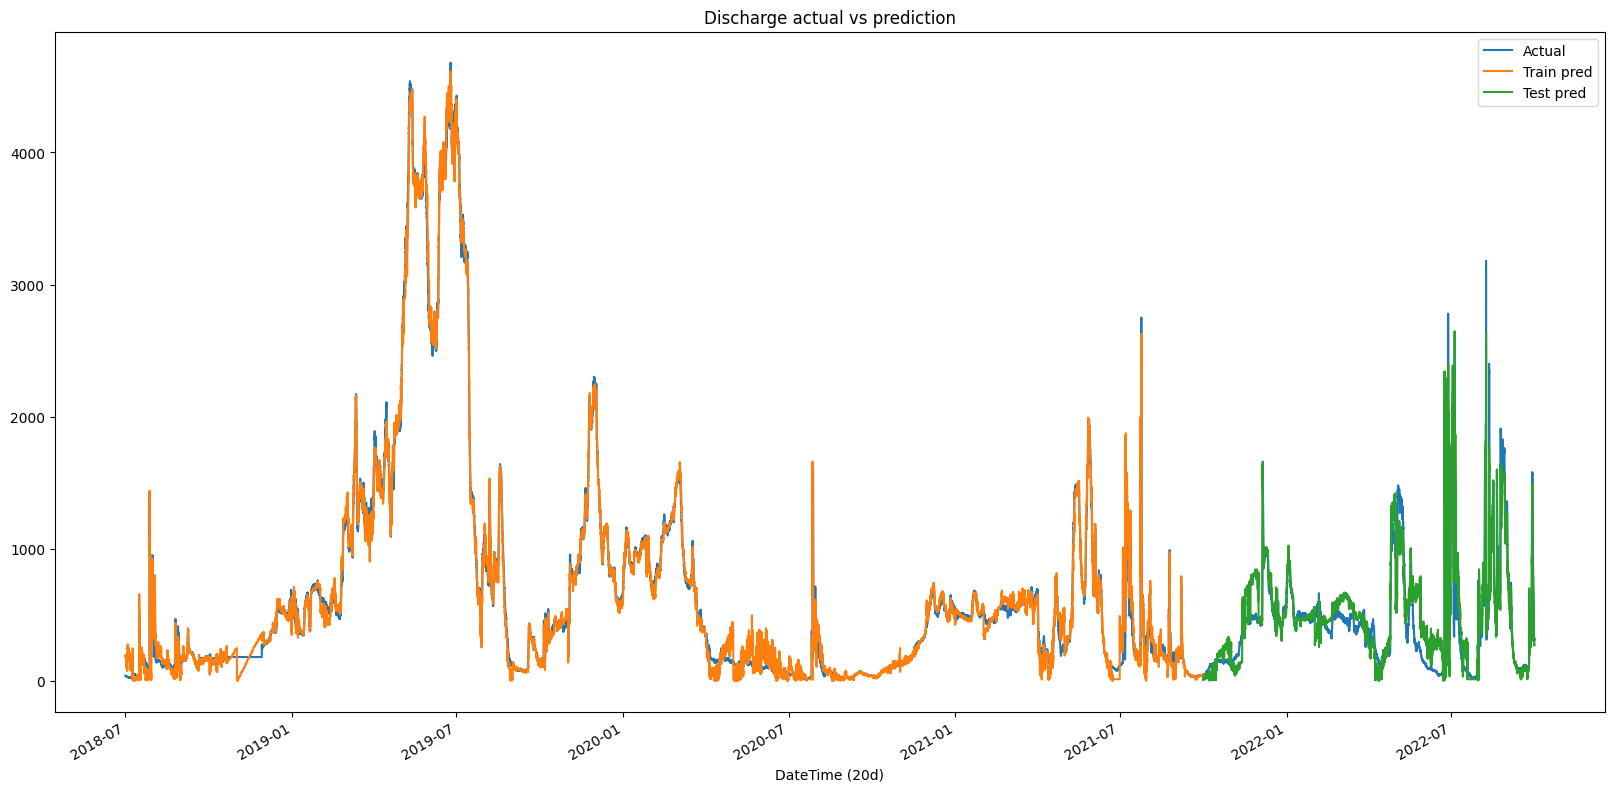

In [14]:
ax = datad.set_index('DateTime (20d)')['Discharge (14n)'].plot(
    legend=True, label='Actual'
)

final_train_predictiond['Discharge (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Discharge actual vs prediction',
    legend=True,
    label='Train pred'
)

final_test_predictiond['Discharge (14n)'].plot(
    ax=ax,
    # linewidth=3,
    # title='Discharge',
    legend=True,
    label='Test pred'
);

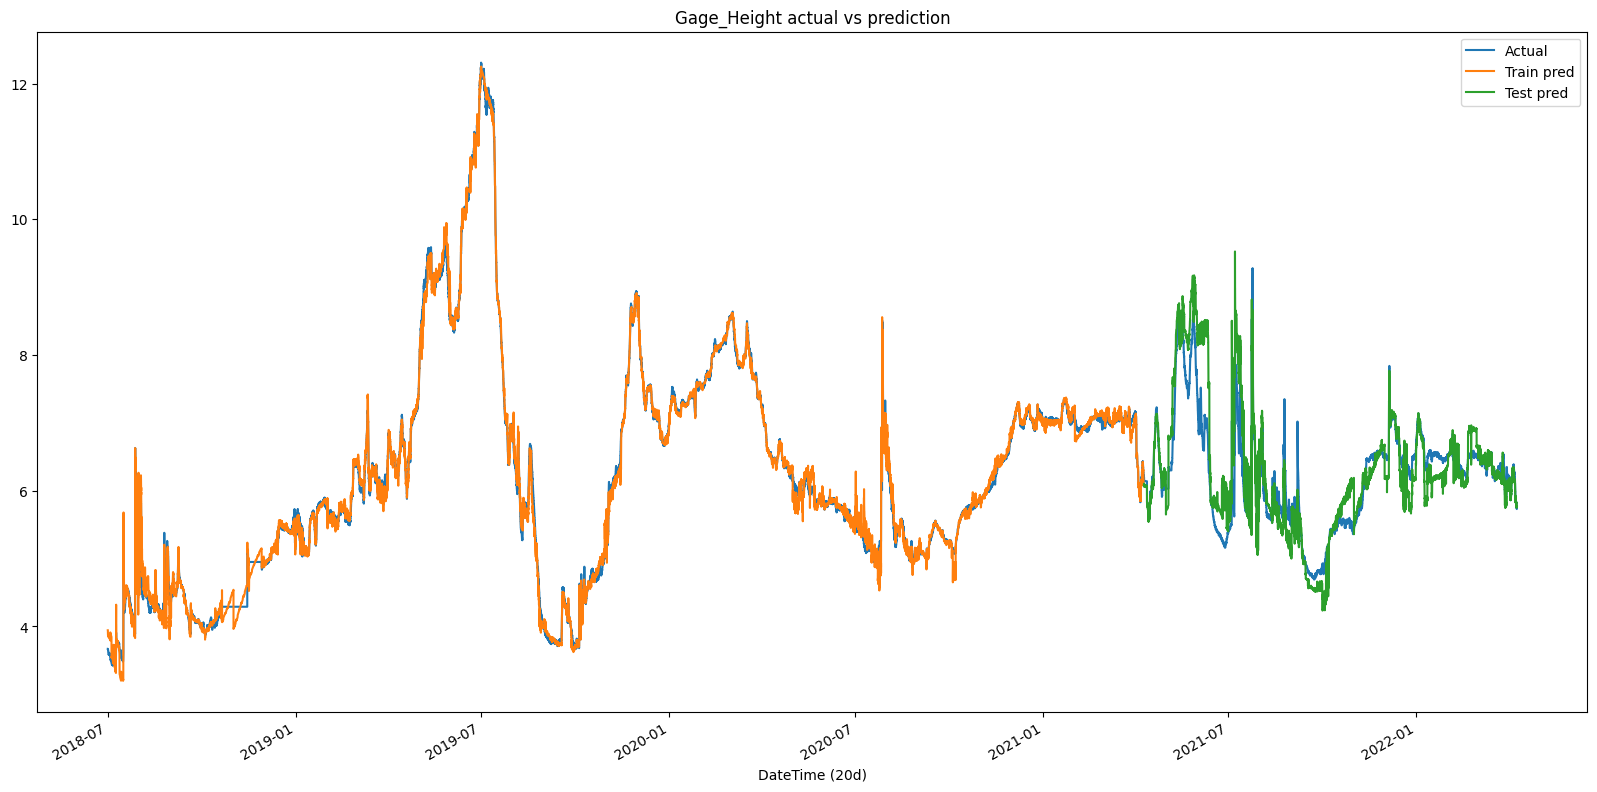

In [15]:
ax = datagh.set_index('DateTime (20d)')['Gage_Height (14n)'].plot(
    legend=True, label='Actual'
)

final_train_predictiongh['Gage_Height (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Gage_Height actual vs prediction',
    legend=True,
    label='Train pred'
)

final_test_predictiongh['Gage_Height (14n)'].plot(
    ax=ax,
    # linewidth=3,
    # title='Gage_Height',
    legend=True,
    label='Test pred'
);

Now let's make the 5 year prediction.

In [16]:
lr_series_predd = lrd.predict(prediction_featuresd[lr_featuresd])
lr_series_predd = pd.DataFrame(lr_series_predd, columns=y_traind.columns)

prediction_featuresd['Discharge (14n)'] = np.zeros(prediction_featuresd.shape[0])

for i in range(1, N_LAGS+1):
    prediction_featuresd[f'lag{i}_discharge'] = np.zeros(prediction_featuresd.shape[0])

for j in tqdm(range(prediction_featuresd.shape[0])):
    for i in range(1, N_LAGS+1):
        if i - j > 0:
            prediction_featuresd.loc[j, f'lag{i}_discharge'] = y_testd.iloc[-i+j]['Discharge (14n)']
            # prediction_featuresgh[f'lag{i}_gage'] = y_testgh.iloc[-i+j]['Gage_Height (14n)']
        else:
            prediction_featuresd.loc[j, f'lag{i}_discharge'] = prediction_featuresd.iloc[j-i]['Discharge (14n)']
            # prediction_featuresgh.loc[j, f'lag{i}_gage'] = prediction_featuresgh.iloc[j-i]['Gage_Height (14n)']

    prediction_featuresd.loc[j, 'Discharge (14n)'] = xgb_discharged.predict(
        np.array(list(prediction_featuresd.iloc[j][discharge_features])).reshape(1, -1)
    )[0]

final_5year_predictiond = prediction_featuresd['Discharge (14n)'] + lr_series_predd['Discharge (14n)']
final_5year_predictiond = final_5year_predictiond.to_frame()

final_5year_predictiond['Discharge (14n)'] = final_5year_predictiond['Discharge (14n)'].apply(
    lambda x: traind['Discharge (14n)'].min()
    if (x <=0 or x < traind['Discharge (14n)'].min())
    else x
)

final_5year_predictiond.index = prediction_featuresd['DateTime (20d)']

100%|██████████| 175200/175200 [17:08<00:00, 170.32it/s]


In [17]:
lr_series_predgh = lrgh.predict(prediction_featuresgh[lr_featuresgh])
lr_series_predgh = pd.DataFrame(lr_series_predgh, columns=y_traingh.columns)

prediction_featuresgh['Gage_Height (14n)'] = np.zeros(prediction_featuresgh.shape[0])

for i in range(1, N_LAGS+1):
    prediction_featuresgh[f'lag{i}_gage'] = np.zeros(prediction_featuresgh.shape[0])


for j in tqdm(range(prediction_featuresgh.shape[0])):
    for i in range(1, N_LAGS+1):
        if i - j > 0:
            prediction_featuresgh[f'lag{i}_gage'] = y_testgh.iloc[-i+j]['Gage_Height (14n)']
        else:
            prediction_featuresgh.loc[j, f'lag{i}_gage'] = prediction_featuresgh.iloc[j-i]['Gage_Height (14n)']

    prediction_featuresgh.loc[j, 'Gage_Height (14n)'] = xgb_gagegh.predict(
        np.array(list(prediction_featuresgh.iloc[j][gage_features])).reshape(1, -1)
    )[0]

final_5year_predictiongh = prediction_featuresgh['Gage_Height (14n)'] + lr_series_predgh['Gage_Height (14n)']
final_5year_predictiongh = final_5year_predictiongh.to_frame()

final_5year_predictiongh['Gage_Height (14n)'] = final_5year_predictiongh['Gage_Height (14n)'].apply(
    lambda x: traingh['Gage_Height (14n)'].min()
    if (x <=0 or x < traingh['Gage_Height (14n)'].min())
    else x
)

final_5year_predictiongh.index = prediction_featuresgh['DateTime (20d)']

100%|██████████| 175200/175200 [16:14<00:00, 179.82it/s]


Finally let's plot the predictions along with actual data.

In [18]:
def get_mean_nooutliers(df, series_name):
    # finding interquantile range
    Q1 = df[series_name].quantile(0.25)
    Q3 = df[series_name].quantile(0.75)
    IQR = Q3 - Q1

    # creating boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_mask = (df[series_name] <= lower_bound) | (df[series_name] >= upper_bound)
    nooutlier_mask = (df[series_name] > lower_bound) | (df[series_name] < upper_bound)

    replace_value = df[nooutlier_mask][series_name].mean()

    return replace_value

In [19]:
# test_predd = final_5year_predictiond['Discharge (14n)'].copy()

In [31]:
# final_5year_predictiond['Discharge (14n)'] = test_predd.values

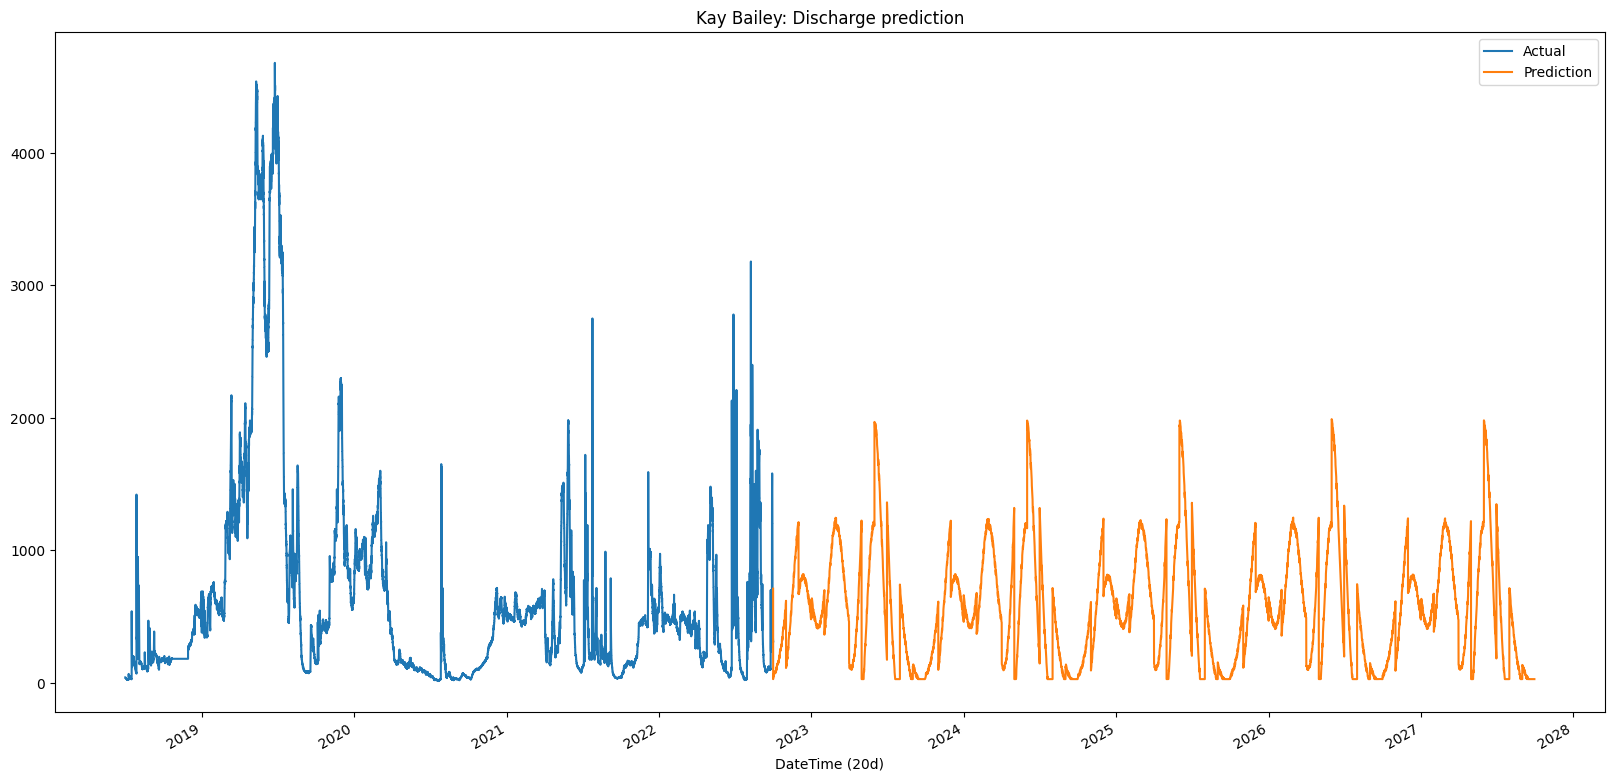

In [32]:
ax = datad.set_index('DateTime (20d)')['Discharge (14n)'].plot(
    legend=True, label='Actual'
)

meand = get_mean_nooutliers(df=traind.copy(), series_name='Discharge (14n)')

final_5year_predictiond['Discharge (14n)'] = (
    2 * meand + \
    final_5year_predictiond['Discharge (14n)']
) * final_5year_predictiond['Discharge (14n)'] /\
final_5year_predictiond['Discharge (14n)'].max()

final_5year_predictiond['Discharge (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Kay Bailey: Discharge prediction',
    legend=True,
    label='Prediction'
);

plt.savefig('Discharge_KayBailey.png', bbox_inches='tight')

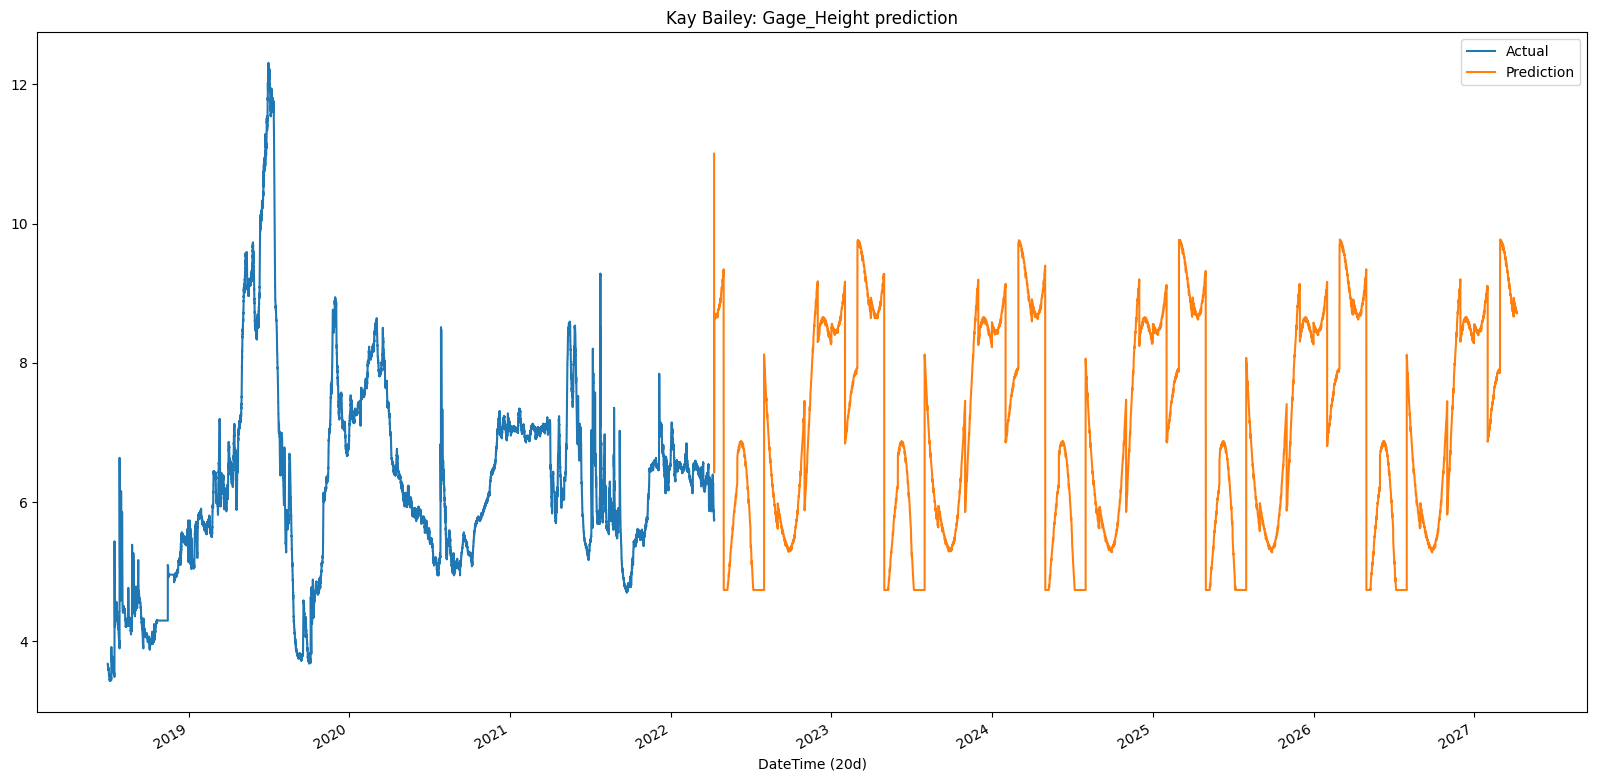

In [21]:
ax = datagh.set_index('DateTime (20d)')['Gage_Height (14n)'].plot(
    legend=True, label='Actual'
)

meangh = get_mean_nooutliers(df=traingh.copy(), series_name='Gage_Height (14n)')

final_5year_predictiongh['Gage_Height (14n)'] = (
    meangh + \
    final_5year_predictiongh['Gage_Height (14n)']
) * final_5year_predictiongh['Gage_Height (14n)'] /\
final_5year_predictiongh['Gage_Height (14n)'].max() - 1


final_5year_predictiongh['Gage_Height (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Kay Bailey: Gage_Height prediction',
    legend=True,
    label='Prediction'
);

plt.savefig('Gage_Height_KayBailey.png', bbox_inches='tight')

Saving the predictions

In [33]:
final_5year_predictiond.to_csv('predictions_discharge.csv')
final_5year_predictiongh.to_csv('predictions_gage.csv')

Let's try to add the spikes to the predictions. First of all let's
derive the average values for spikes and duration between them.

In [23]:
def get_spikes(
    df, series_name, multiplier1=4,
    multiplier2=None, acceptable_diff=15,
    main_data=datad, pred_data=prediction_featuresd
):

    # finding interquantile range
    Q1 = df[series_name].quantile(0.25)
    Q3 = df[series_name].quantile(0.75)
    IQR = Q3 - Q1

    # creating boundaries
    lower_bound1 = Q1 - multiplier1 * IQR
    upper_bound1 = Q3 + multiplier1 * IQR

    # identifying outliers/spikes
    if multiplier2 is None:
        outliers = df[
            (df[series_name] < lower_bound1) | (df[series_name] > upper_bound1)
        ][['DateTime (20d)', series_name]]

        outliers2 = main_data[
            (main_data[series_name] < lower_bound1) | (main_data[series_name] > upper_bound1)
        ][['DateTime (20d)', series_name]]
    else:
        lower_bound2 = Q1 - multiplier2 * IQR
        upper_bound2 = Q3 + multiplier2 * IQR
        outliers = df[
            ((df[series_name] < lower_bound1) & ((df[series_name] > lower_bound2))) |
            ((df[series_name] > upper_bound1) & (df[series_name] < upper_bound2))
        ][['DateTime (20d)', series_name]]

        outliers2 = main_data[
            ((main_data[series_name] < lower_bound1) & ((main_data[series_name] > lower_bound2))) |
            ((main_data[series_name] > upper_bound1) & (main_data[series_name] < upper_bound2))
        ][['DateTime (20d)', series_name]]

    # finding the mean value of spikes for the series
    # spike_mean_value = outliers[series_name].median()
    spike_mean_value = outliers[
        outliers[series_name]>=outliers[series_name].median()
    ][series_name].mean()

    # finding the average period between spikes
    outliers.sort_values('DateTime (20d)', ascending=True, inplace=True)
    outliers.reset_index(inplace=True, drop=True)
    spike_mean_freq = int(
        (
            outliers[
                outliers['DateTime (20d)'].diff().dt.total_seconds()/60>acceptable_diff
            ]['DateTime (20d)'].diff().dt.total_seconds()/60
        ).max()
    )

    last_date = outliers2[
        outliers2['DateTime (20d)'].diff().dt.total_seconds()/60>acceptable_diff
    ].iloc[-1]['DateTime (20d)']

    spike_mean_freq15 = int(spike_mean_freq - spike_mean_freq % 15)

    future_occurance_dates = []
    spike_freq_multiplier = 7
    while last_date < pred_data.iloc[-1]['DateTime (20d)']:
        next_last_date = last_date + timedelta(seconds=spike_freq_multiplier*spike_mean_freq15)
        if next_last_date > main_data.iloc[-1]['DateTime (20d)']:
            future_occurance_dates.append(next_last_date)
        last_date = next_last_date

    # finding dates related to outliers/spikes
    outliers_date = list(outliers['DateTime (20d)'])

    # plotting spikes in line with the series
    fig = plt.figure(figsize=(20, 10))
    plt.plot(df['DateTime (20d)'], df[series_name])
    for i in range(len(outliers_date)):
        plt.axvline(outliers_date[i], color='orange', alpha=0.01)
    plt.xticks(rotation=45)
    plt.title('Spikes used during calculation')
    plt.show()

    return spike_mean_value, future_occurance_dates

##### Value pair 1 #####


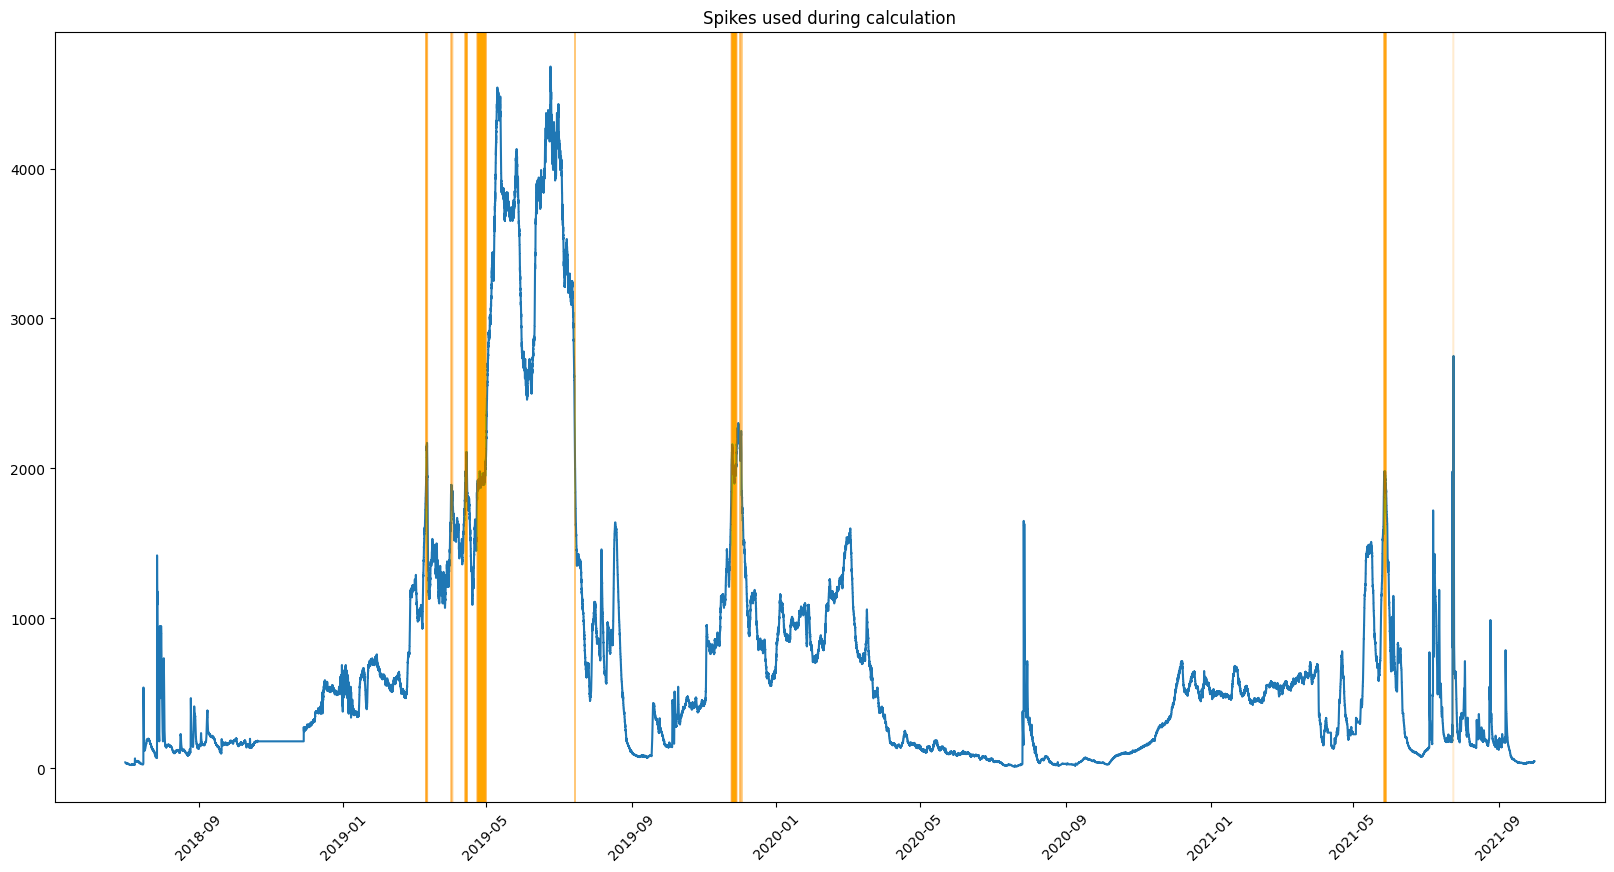

##### Value pair 2 #####


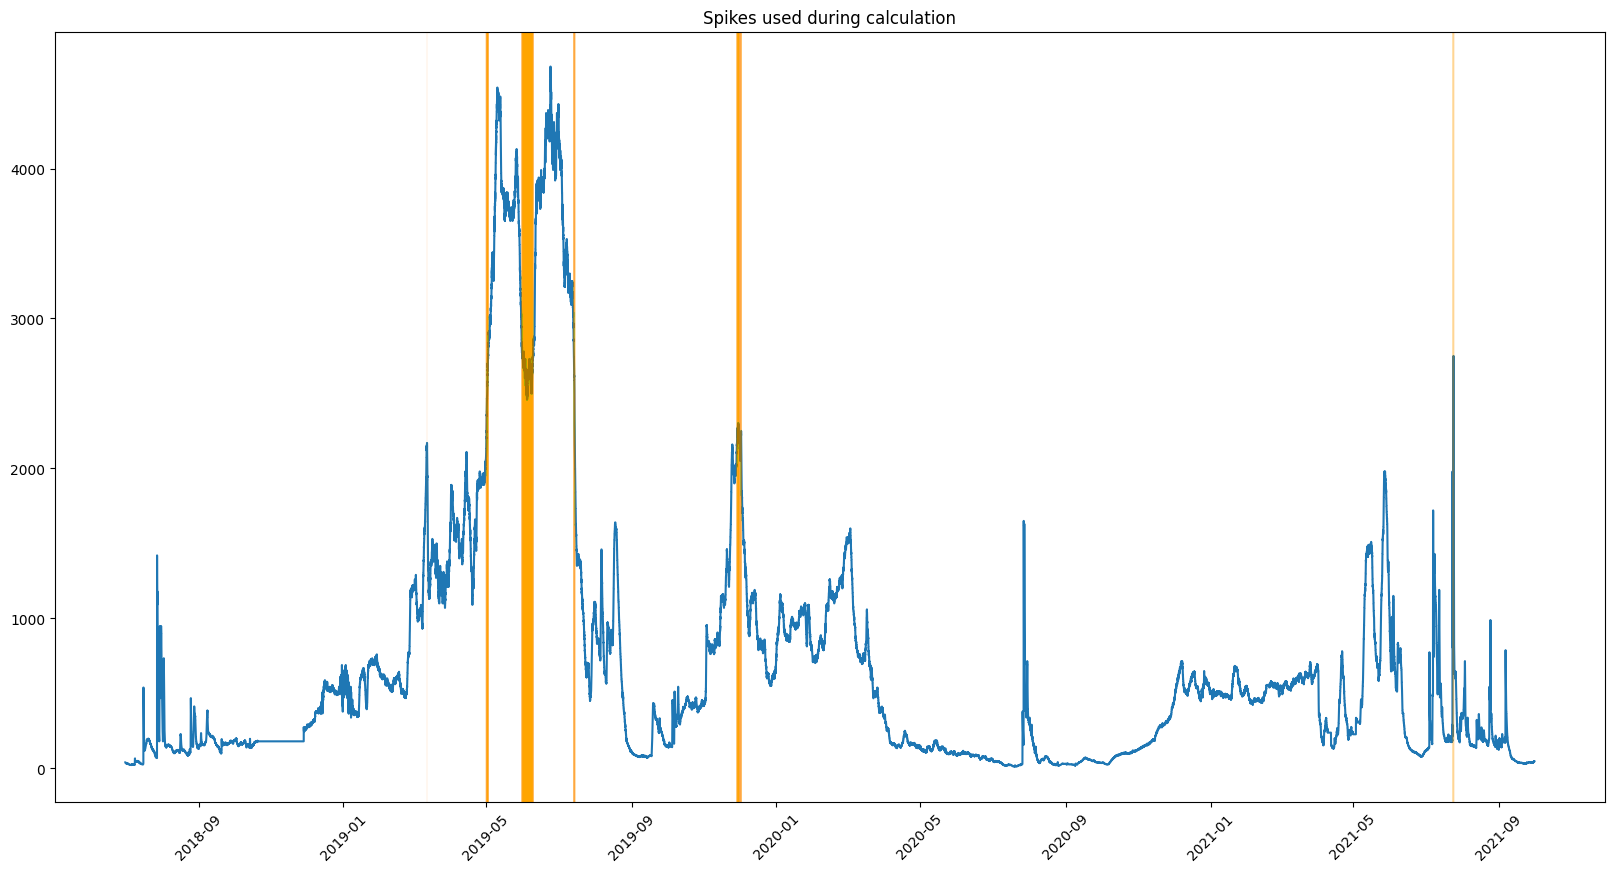

##### Value pair 3 #####


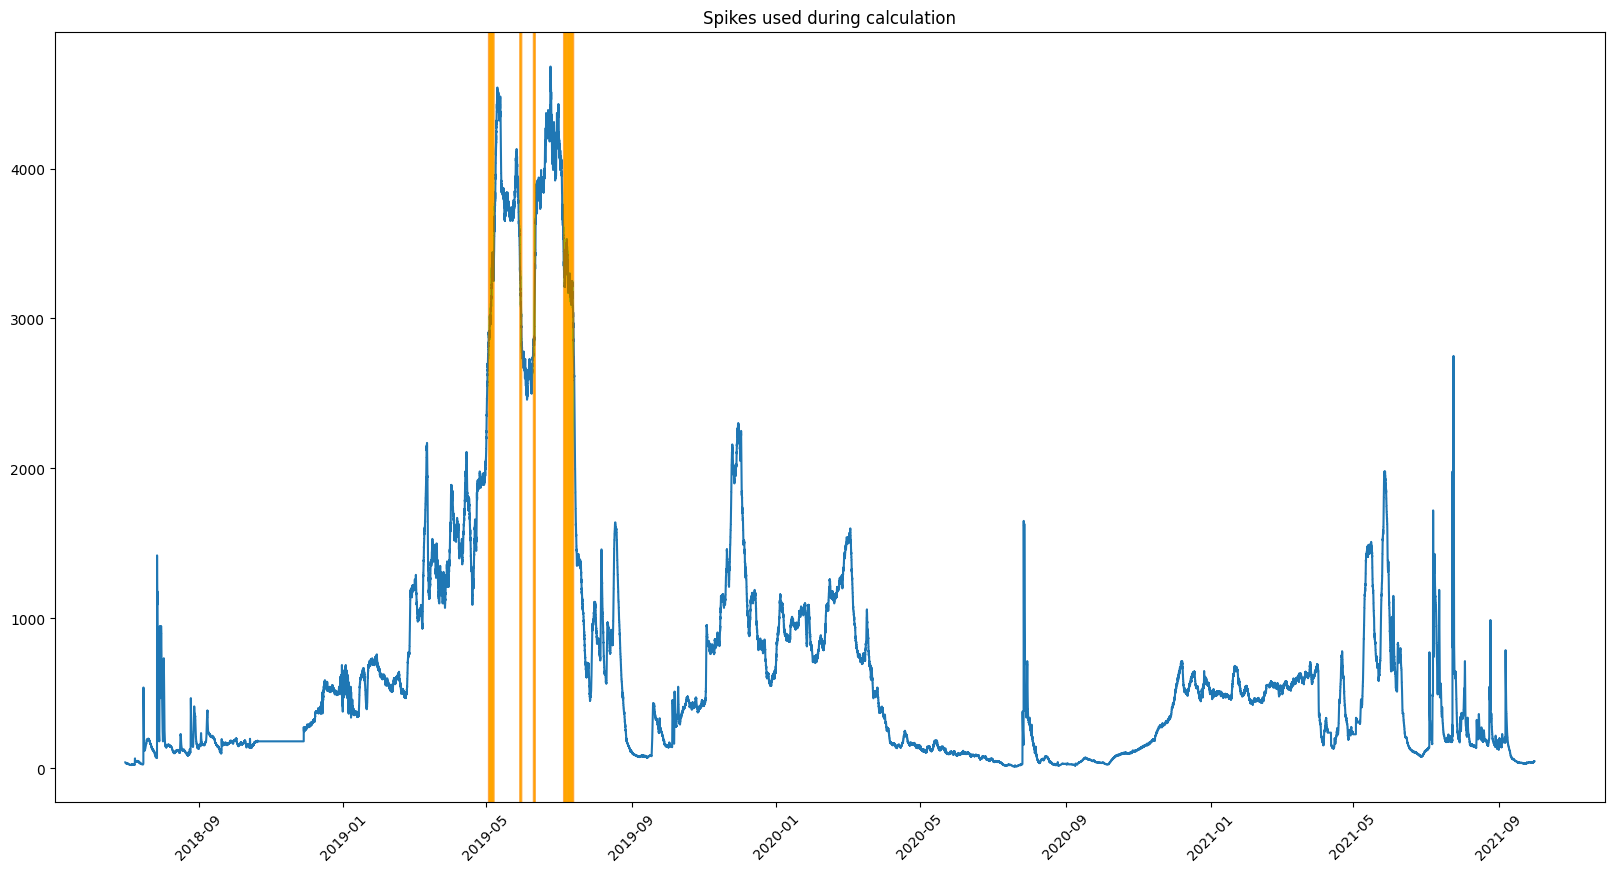

In [24]:
multiplier_list1 = [1.5, 2, 3]
multiplier_list2 = [2, 3, 4]

discharge_spikes_list = []

for i in range(len(multiplier_list1)):

    print(f'##### Value pair {i+1} #####')

    try:

        discharge_spike_mean_value, future_occurance_dates = get_spikes(
            df=traind,
            series_name='Discharge (14n)',
            multiplier1=multiplier_list1[i],
            multiplier2=multiplier_list2[i]
        )

        discharge_spikes_list.append(
            (
                discharge_spike_mean_value,
                future_occurance_dates
            )
        )

    except:
        pass

##### Value pair 1 #####


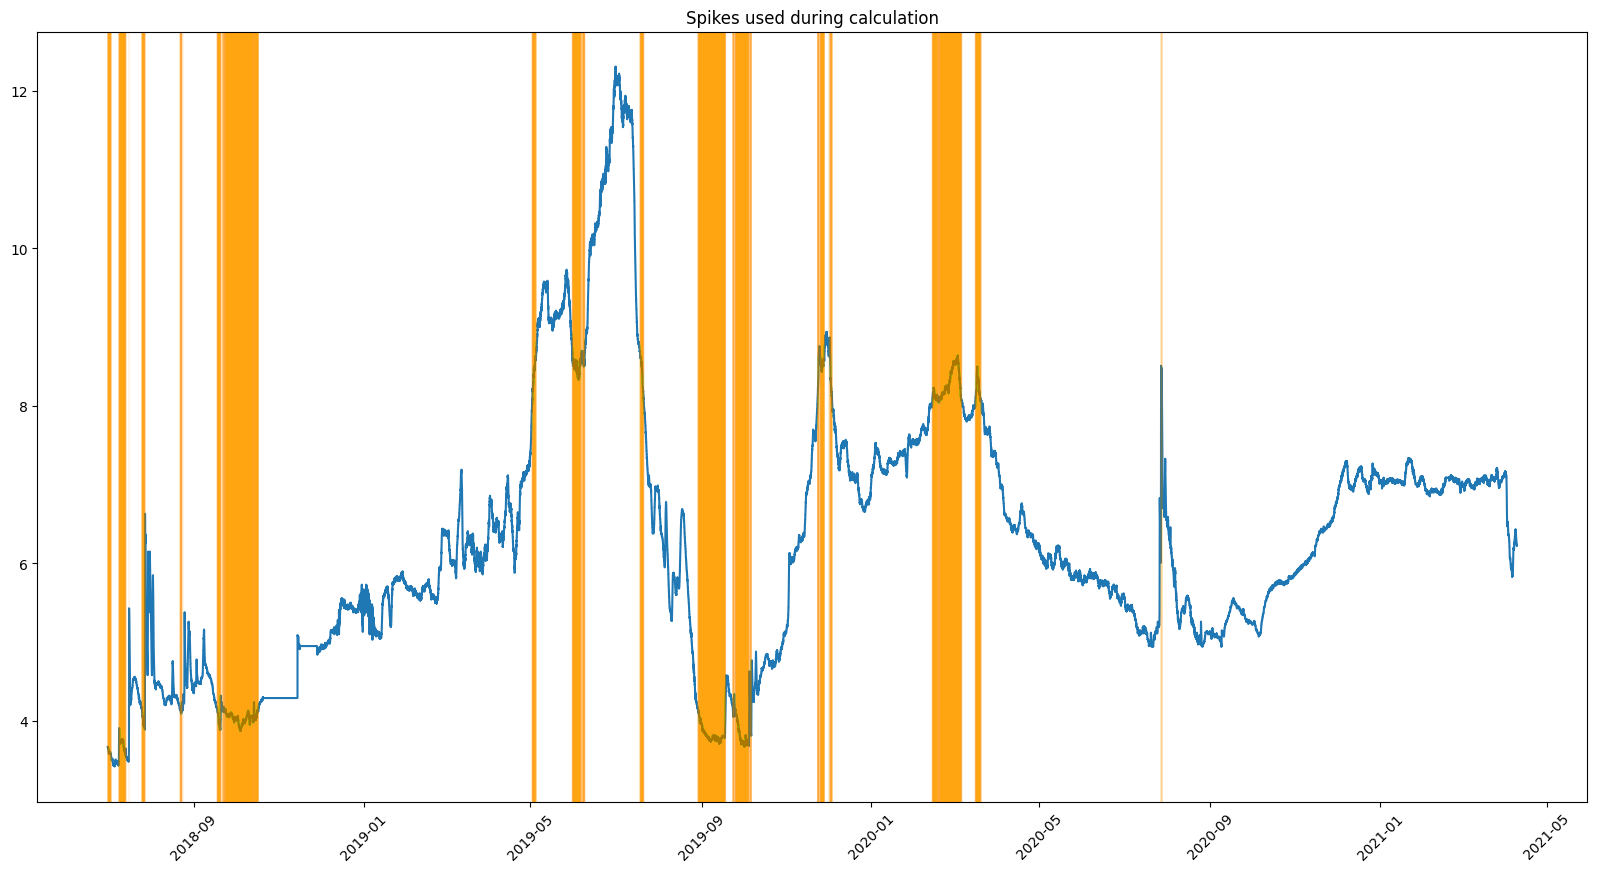

##### Value pair 2 #####


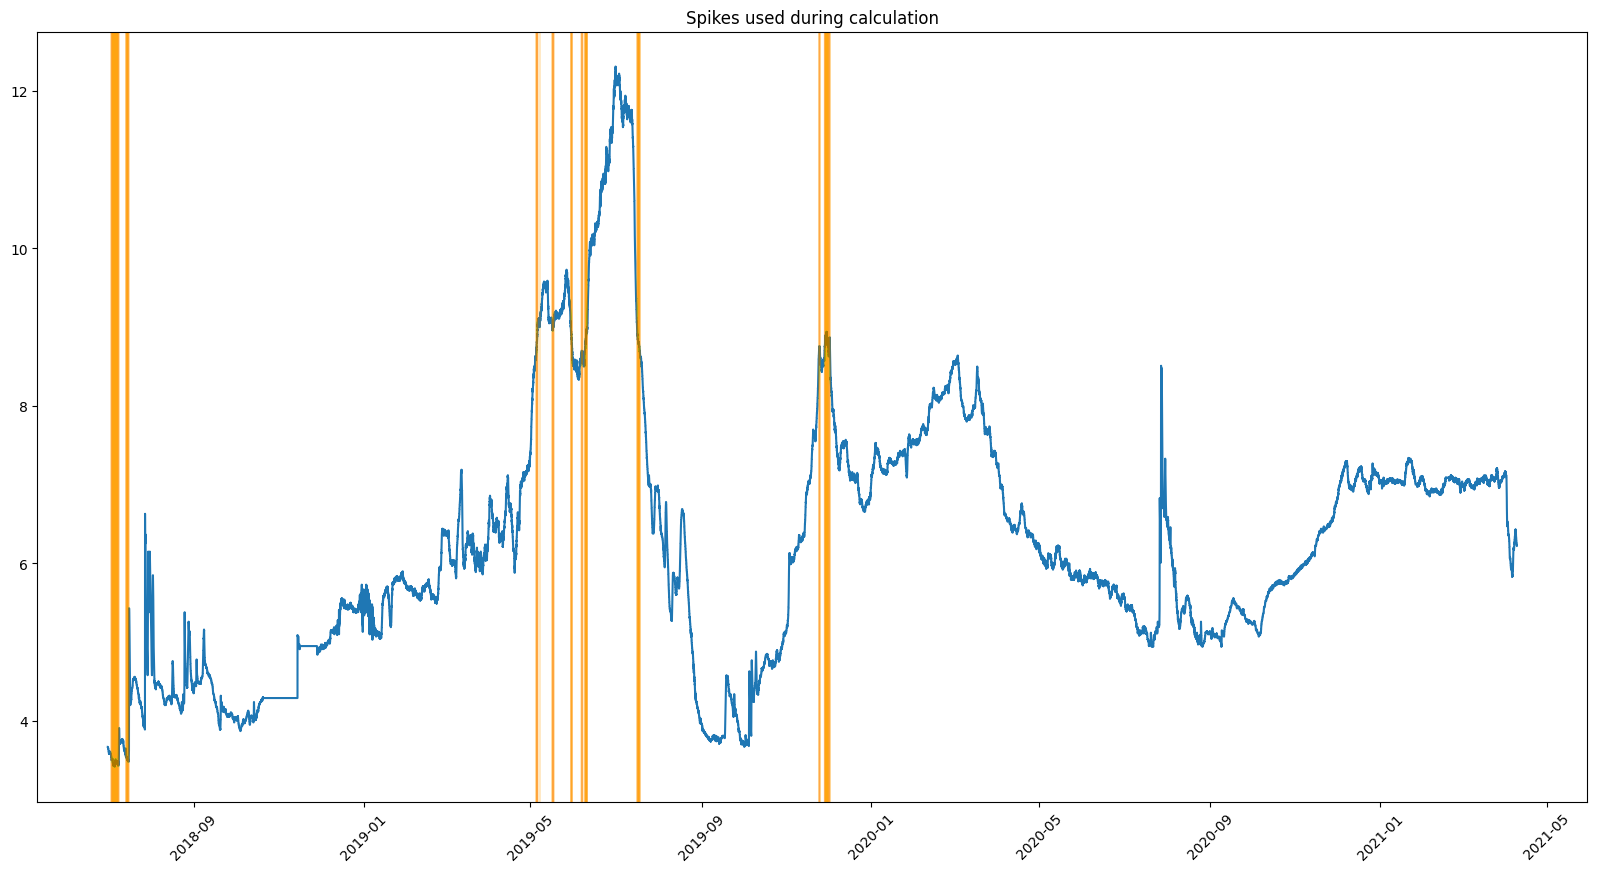

In [25]:
multiplier_list1 = [0.5, 0.8]
multiplier_list2 = [0.8, 1]

gage_spikes_list = []

for i in range(len(multiplier_list1)):

    print(f'##### Value pair {i+1} #####')

    try:

        gage_spike_mean_value, future_occurance_dates = get_spikes(
            df=traingh,
            series_name='Gage_Height (14n)',
            multiplier1=multiplier_list1[i],
            multiplier2=multiplier_list2[i],
            main_data=datagh,
            pred_data=prediction_featuresgh
        )

        gage_spikes_list.append(
            (
                gage_spike_mean_value,
                future_occurance_dates
            )
        )
    except:
        pass

Now we can try to incorporate the spikes into the prediction process and see the results.

In [34]:
max_discharge = traind['Discharge (14n)'].max()

max_gage = traingh['Gage_Height (14n)'].max()

new_discharge_spikes_list = []

for i in range(len(discharge_spikes_list)):
    new_discharge_spikes_list.append(([], discharge_spikes_list[i][1]))
    for j in range(len(discharge_spikes_list[i][1])):
        temp_diff = max_discharge - discharge_spikes_list[i][0]
        np.random.seed(j)
        temp_diff = temp_diff * np.random.rand()
        temp_spike = temp_diff + discharge_spikes_list[i][0]
        new_discharge_spikes_list[i][0].append(temp_spike)

# new_gage_spikes_list = []

# for i in range(len(gage_spikes_list)):
#     new_gage_spikes_list.append(([], gage_spikes_list[i][1]))
#     for j in range(len(gage_spikes_list[i][1])):
#         temp_diff = max_gage - gage_spikes_list[i][0]
#         np.random.seed(j)
#         temp_diff = temp_diff * np.random.rand()
#         temp_spike = temp_diff + gage_spikes_list[i][0]
#         new_gage_spikes_list[i][0].append(temp_spike)

In [27]:
# final_5year_prediction = pd.read_csv('predictions.csv')
# final_5year_prediction['DateTime (20d)'] = pd.to_datetime(final_5year_prediction['DateTime (20d)'])

for i in range(len(new_discharge_spikes_list)):
    for j in range(len(new_discharge_spikes_list[i][1])):
        final_5year_predictiond.loc[
            final_5year_predictiond.index==new_discharge_spikes_list[i][1][j],
            'Discharge (14n)'
        ] = new_discharge_spikes_list[i][0][j]

# for i in range(len(new_gage_spikes_list)):
#     for j in range(len(new_gage_spikes_list[i][1])):
#         final_5year_predictiongh.loc[
#             final_5year_predictiongh.index==new_gage_spikes_list[i][1][j],
#             'Gage_Height (14n)'
#         ] = new_gage_spikes_list[i][0][j]

# Function to find peaks in a time series
def find_peaks(series, threshold=0.5):
    peaks = (series > series.shift(1)) & \
        (series > series.shift(-1)) & \
        (series.shift(1) > series.shift(2)) &\
        (series.shift(-1) > series.shift(-2))
    # peaks = peaks & (series > threshold)
    return peaks

# final_5year_predictiond['is_peak'] = find_peaks(final_5year_predictiond['Discharge (14n)'])
# final_5year_predictiond.loc[final_5year_predictiond['is_peak'], 'Discharge (14n)'] = final_5year_predictiond.loc[final_5year_predictiond['is_peak'], 'Discharge (14n)'] + traind['Discharge (14n)'].mean()

final_5year_predictiongh['is_peak'] = find_peaks(final_5year_predictiongh['Gage_Height (14n)'])
final_5year_predictiongh.loc[final_5year_predictiongh['is_peak'], 'Gage_Height (14n)'] = final_5year_predictiongh.loc[final_5year_predictiongh['is_peak'], 'Gage_Height (14n)'] + traingh['Gage_Height (14n)'].mean()

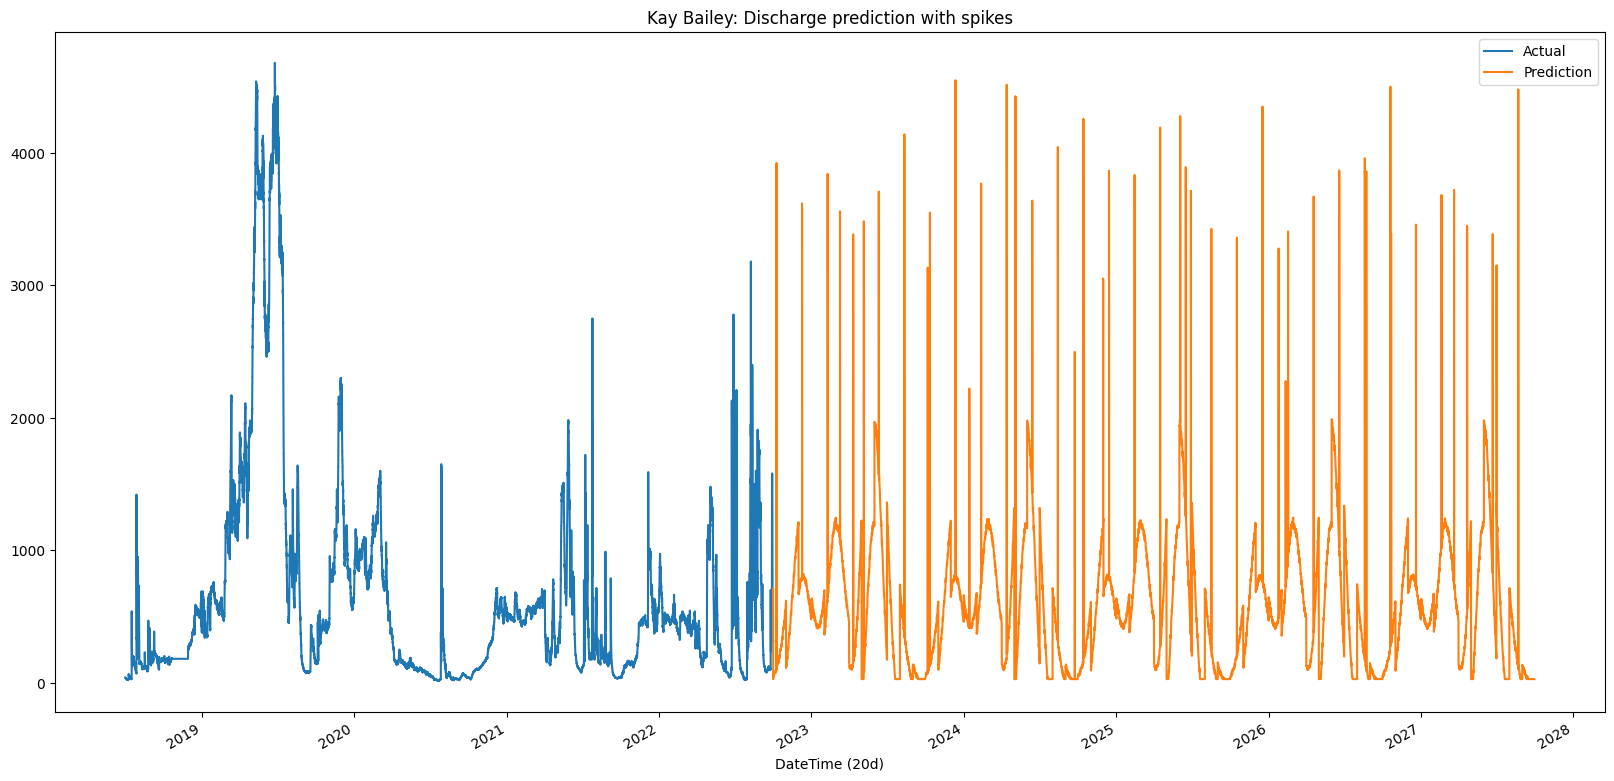

In [36]:
ax = datad.set_index('DateTime (20d)')['Discharge (14n)'].plot(
    legend=True, label='Actual'
)

final_5year_predictiond['Discharge (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Kay Bailey: Discharge prediction with spikes',
    legend=True,
    label='Prediction'
);

plt.savefig('Discharge_KayBailey_spikes.png', bbox_inches='tight')

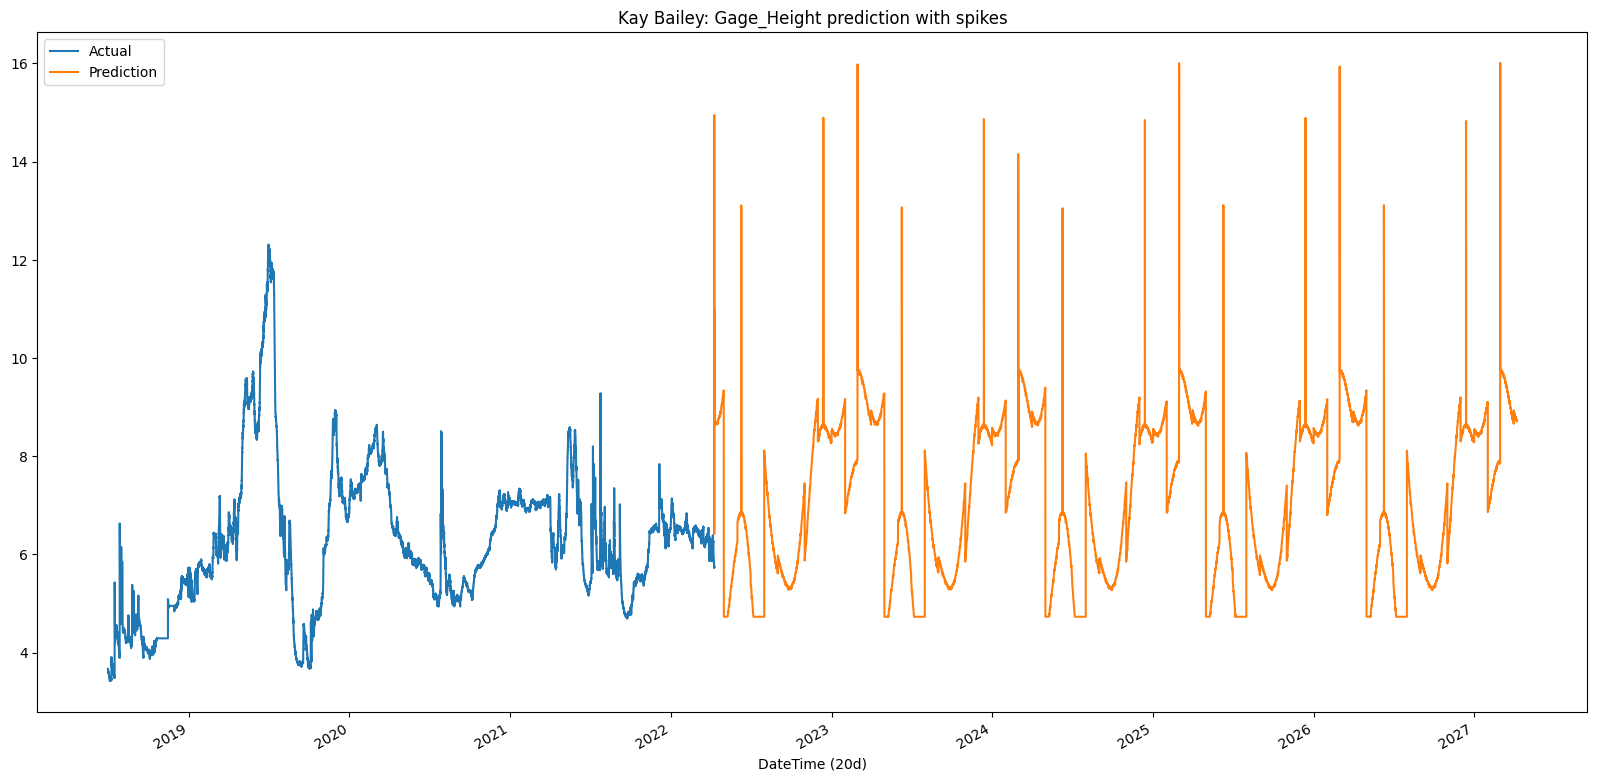

In [29]:
ax = datagh.set_index('DateTime (20d)')['Gage_Height (14n)'].plot(
    legend=True, label='Actual'
)

final_5year_predictiongh['Gage_Height (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Kay Bailey: Gage_Height prediction with spikes',
    legend=True,
    label='Prediction'
);

plt.savefig('Gage_Height_KayBailey_spikes.png', bbox_inches='tight')

Saving the output

In [38]:
final_5year_predictiond.to_csv('predictions_spikes_included_discharge.csv')
final_5year_predictiongh.to_csv('predictions_spikes_included_gage.csv')